In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt

# Import Object Detection Model

In [2]:
model = YOLO("./models/best.pt")


image 1/20 /home/abhinna/ub/research/model/data/test/images/da5d9b39-1.JPG: 640x480 1 Gauge, 1 StationLabel, 61.1ms
image 2/20 /home/abhinna/ub/research/model/data/test/images/dc7d48b0-60.jpg: 640x480 1 Gauge, 1 StationLabel, 5.8ms
image 3/20 /home/abhinna/ub/research/model/data/test/images/dd064be4-63.jpg: 640x480 1 Gauge, 1 StationLabel, 5.2ms
image 4/20 /home/abhinna/ub/research/model/data/test/images/dd600dad-9.JPG: 640x480 1 Gauge, 1 StationLabel, 5.0ms
image 5/20 /home/abhinna/ub/research/model/data/test/images/dfa354af-14.JPG: 640x480 1 Gauge, 1 StationLabel, 5.5ms
image 6/20 /home/abhinna/ub/research/model/data/test/images/e009bacb-56.jpg: 640x480 1 Gauge, 1 StationLabel, 5.2ms
image 7/20 /home/abhinna/ub/research/model/data/test/images/e100c06a-28.JPG: 640x480 1 Gauge, 1 StationLabel, 5.3ms
image 8/20 /home/abhinna/ub/research/model/data/test/images/e1f994b5-49.jpg: 640x480 1 Gauge, 1 StationLabel, 5.2ms
image 9/20 /home/abhinna/ub/research/model/data/test/images/e74a58cf-78.

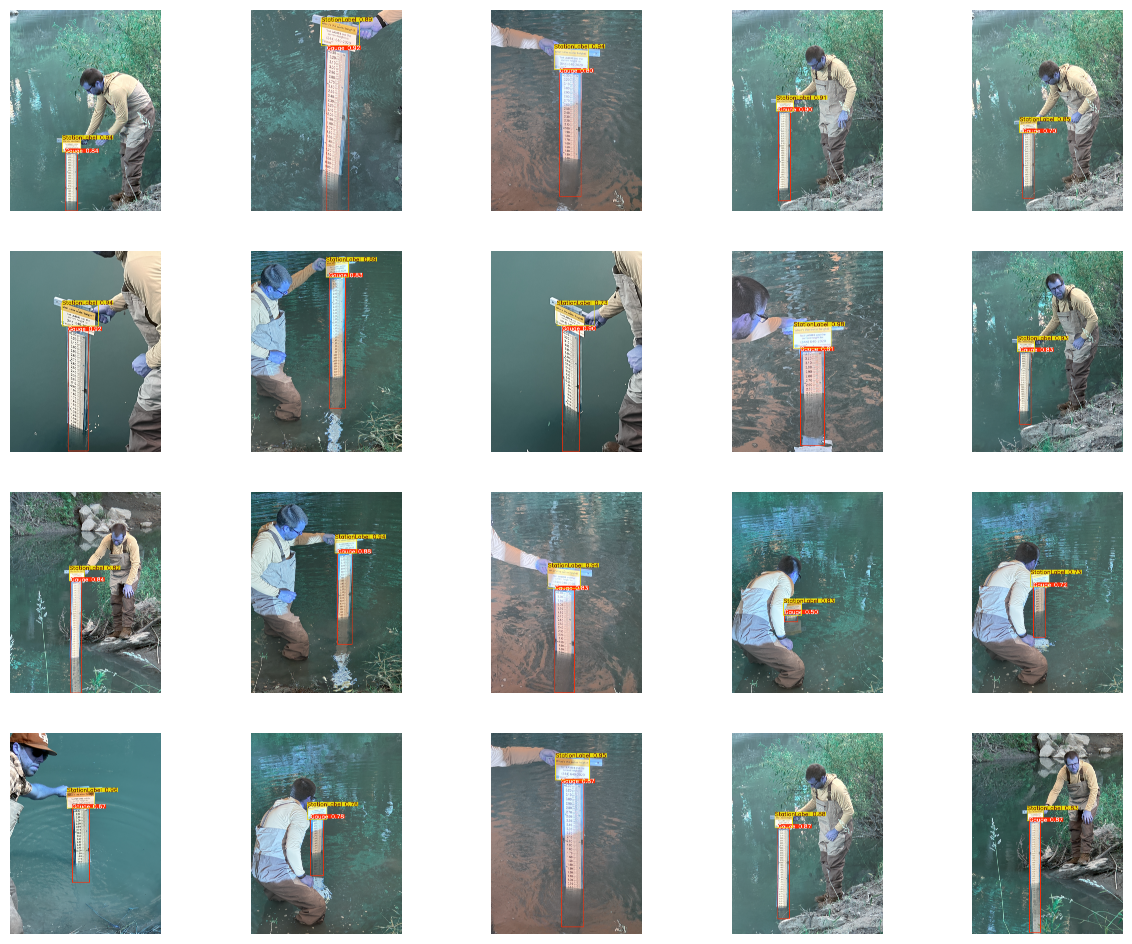

In [3]:
pred = model.predict("./data/test/images")

# Reference: https://docs.ultralytic.com/modes/predict/#key-features-of-predict-mode
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
for i, result in enumerate(pred):
    # Get annotated image
    row = i // 5
    col = i % 5
    pred_img = result.plot()

    # Show with matplotlib
    axes[row, col].imshow(pred_img)
    axes[row, col].axis('off')
plt.show()

# Extract Station Label

In [4]:
labels = pred[0].names
labels

{0: 'Gauge', 1: 'StationLabel'}

In [5]:
pred[0].boxes[0].cls.cpu().numpy().astype(int)

array([1])

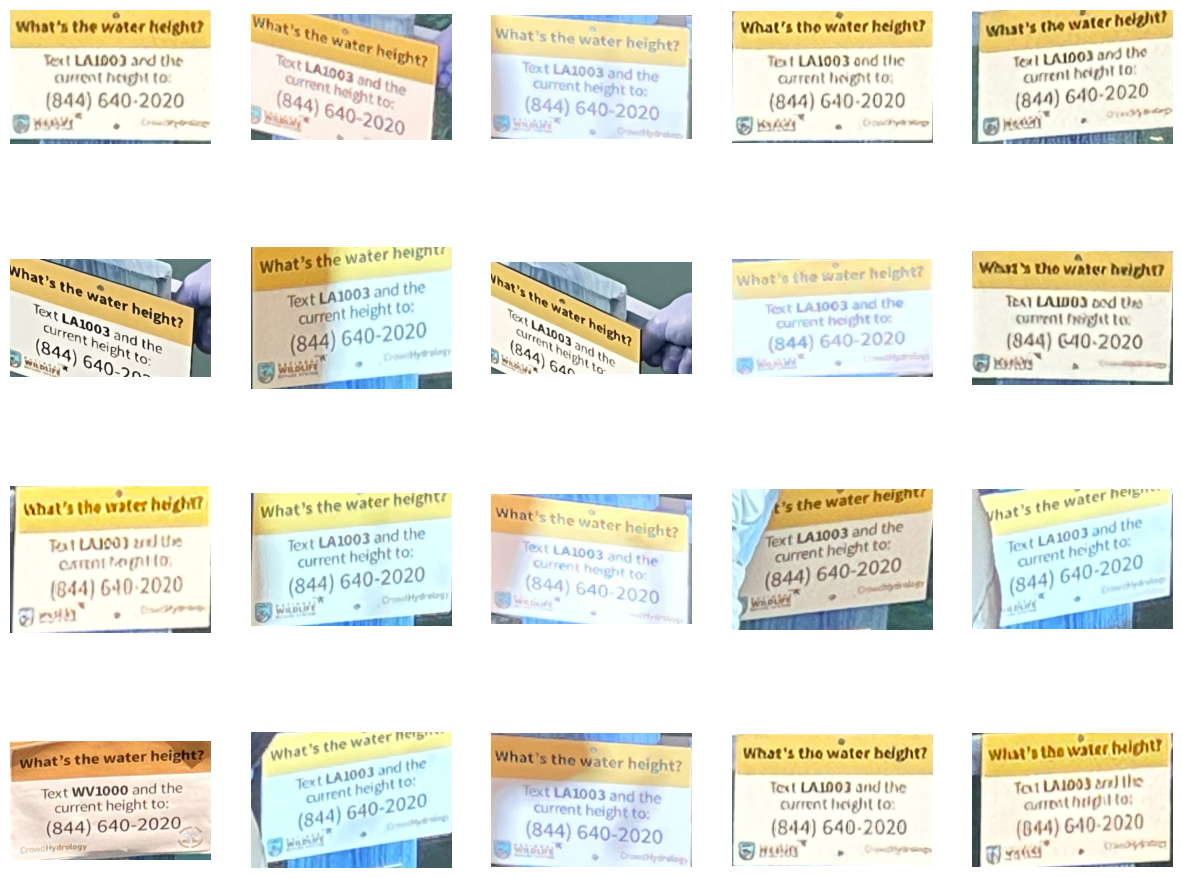

In [6]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, prediction in enumerate(pred):
    label_name = model.names[0]
    row = i // 5
    col = i % 5

    label1, label2 = prediction.boxes[0].cls.cpu().numpy().astype(int)[0], prediction.boxes[1].cls.cpu().numpy().astype(int)[0]

    x1, y1, x2, y2 = map(int, prediction[1].boxes[0].xyxy[0]) if label1 == 0 else map(int, prediction[0].boxes[0].xyxy[0])
    stationLabel = prediction.plot(labels=False, boxes=False)[y1:y2, x1:x2]

    axes[row, col].imshow(stationLabel)
    axes[row, col].axis('off')

plt.show()

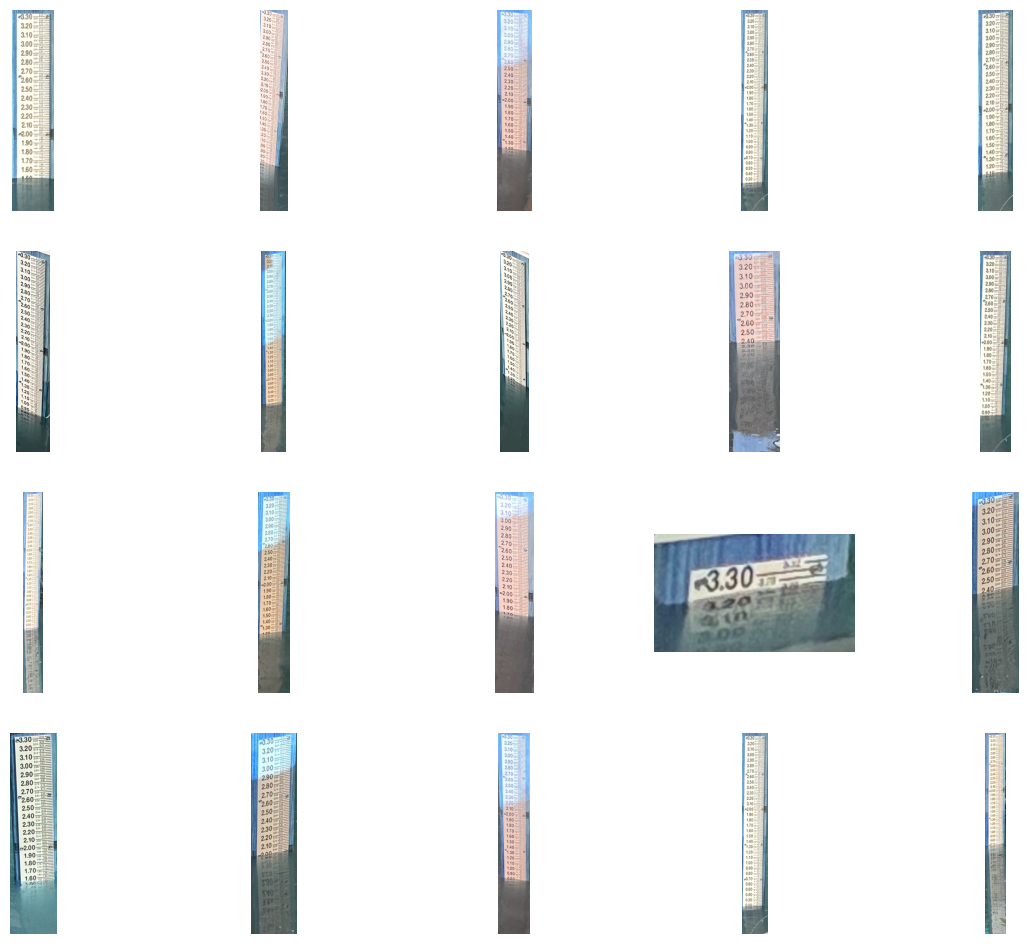

In [7]:
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, prediction in enumerate(pred):
    row = i // 5
    col = i % 5

    label1, label2 = prediction.boxes[0].cls.cpu().numpy().astype(int)[0], prediction.boxes[1].cls.cpu().numpy().astype(int)[0]

    x1, y1, x2, y2 = map(int, prediction[1].boxes[0].xyxy[0]) if label1 == 1 else map(int, prediction[0].boxes[0].xyxy[0])
    stationLabel = prediction.plot(labels=False, boxes=False)[y1:y2, x1:x2]

    axes[row, col].imshow(stationLabel)
    axes[row, col].axis('off')

plt.show()

# Preprocess Images

# Helpers

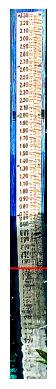

In [24]:
from abc import ABC, abstractmethod
from PIL import Image, ImageFilter, ImageEnhance, ImageOps
import numpy as np
from typing import Any

import cv2

class AbstractPreprocessor(ABC):
    @abstractmethod
    def preprocess(self, img: Any) -> np.ndarray:
        pass

    def to_pil(self, img: Any) -> Image.Image:
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        return img

    def to_grayscale(self, img: Image.Image) -> Image.Image:
        return img.convert("L")

    def enhance_contrast(self, img: Image.Image, factor: float = 2.0) -> Image.Image:
        return ImageEnhance.Contrast(img).enhance(factor)

    def sharpen(self, img: Image.Image) -> Image.Image:
        return img.filter(ImageFilter.SHARPEN)

    def invert(self, img: Image.Image) -> Image.Image:
        return ImageOps.invert(img)

    def normalize(self, img: Image.Image) -> np.ndarray:
        return np.array(img) / 255.0
    
    def resize(self, img: Image.Image, size: tuple[int, int]) -> Image.Image:
        return img.resize(size, Image.LANCZOS)

    def denoise(self, img: Image.Image) -> Image.Image:
        return img.filter(ImageFilter.MedianFilter(size=3))

    def adaptive_threshold(self, img: Image.Image, window_size = 9) -> Image.Image:
        arr = img if type(img) is np.array else np.array(img)
        thresh = cv2.adaptiveThreshold(
            arr, 255,
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY,
            window_size,
            2
        )
        return Image.fromarray(thresh)

    def equalize(self, img: Image.Image) -> Image.Image:
        arr = np.array(img)
        eq = cv2.equalizeHist(arr)
        return Image.fromarray(eq)

class StationLabelPreprocessor(AbstractPreprocessor):
    def preprocess(self, img: Any) -> np.ndarray:
        # Initial conversion
        img = self.to_pil(img)
        
        # Basic preprocessing
        img = self.to_grayscale(img)
        
        # resize
        img = self.resize(img, (400, 300))  # Wider size for better text aspect ratio
        
        # Enhancement sequence
        img = self.enhance_contrast(img, factor=2.5)  # Increased contrast
        img = self.denoise(img)  # Remove noise after contrast
        img = self.equalize(img)  # Balance the brightness
        img = self.sharpen(img)  # Make text crisper
        
        # Thresholding with modified parameters
        img = self.adaptive_threshold(img)
        
        # Final normalization
        img = self.normalize(img)
        return img


class GaugePreprocessor(AbstractPreprocessor):
    def _output_enhance(self, img: Image.Image):
        img = self._resize_by_height(img, 600)
        # img = self.to_grayscale(img)
        img = self.enhance_contrast(img, factor=3)
        img = self.sharpen(img)
        img = np.array(img)
        # img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        return img
    def preprocess(self, img: Any) -> np.ndarray:
        
        # 1) PIL → Grayscale → proportional resize
        pil = self.to_pil(img)
        original_img = pil.copy()

        img = self.to_grayscale(pil)
        img = self._resize_by_height(img, 600)

        blurred = cv2.GaussianBlur(np.array(img), (5, 5), sigmaX=1.5)
        img = Image.fromarray(blurred)

        # 2) Denoise & contrast
        img = img.filter(ImageFilter.MedianFilter(3))
        # img = ImageEnhance.Contrast(img).enhance(3)
        # img = img.filter(ImageFilter.SHARPEN)

        # 3) Convert to numpy gray for waterline detection
        arr_gray = np.array(img, dtype=np.uint8)

        # 4) Detect waterline (paper’s method)
        row, cleaned = self.detect_waterline(arr_gray)

        # 5) Mark that waterline on an RGB version
        rgb = cv2.cvtColor(arr_gray, cv2.COLOR_GRAY2BGR)

        original_img = self._output_enhance(original_img)

        marked = self.mark_waterline(np.array(original_img), row)
        # marked = self.mark_waterline(original_img, row)
        # marked = self.mark_waterline(cleaned, row)

        # 6) Normalize and return
        marked_norm = marked.astype(np.float32) / 255.0
        return marked_norm

    def _resize_by_height(self, img: Image.Image, target_h: int) -> Image.Image:
        w, h = img.size
        new_w = int(w * (target_h / h))
        return img.resize((new_w, target_h), Image.LANCZOS)

    def detect_waterline(self, img_gray: np.ndarray) -> tuple[int, np.ndarray]:
        H, W = img_gray.shape

        # 1) Lightly smooth to suppress tiny specks
        img_gray = cv2.GaussianBlur(img_gray, (5, 5), 1.5)
        img_gray = cv2.medianBlur(img_gray, 5)
        
        # top-hat to remove uneven lighting
        kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
        tophat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, kernel1)

        # contrast stretch + Otsu threshold
        minV, maxV = tophat.min(), tophat.max()
        stretched = ((tophat - minV) * (255.0 / (maxV - minV))).astype(np.uint8)
        _, binary = cv2.threshold(stretched, 0, 255, cv2.THRESH_OTSU)

        # close then open to clean
        kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
        closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel2)
        cleaned = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel2)

        # sum white pixels per row → first row above threshold
        row_sums = cleaned.sum(axis=1)
        thresh = 0.5 * row_sums.max()                # e.g. 10% of max

        # Reverse scan: bottom row → top row
        rev = row_sums[::-1]                         # flips it end←→start
        rev_idx = int(np.argmax(rev > thresh))       # first “hit” in reversed
        water_row = (cleaned.shape[0] - 1) - rev_idx  # map back to original row
        
        return water_row, cleaned

    def mark_waterline(self, rgb_img: np.ndarray, row: int) -> np.ndarray:
        marked = rgb_img.copy()
        cv2.line(marked, (0, row), (marked.shape[1] - 1, row), (255, 0, 0), 2)
        return marked
    


if __name__ == "__main__":
    prediction=pred[19]
    label1, label2 = prediction.boxes[0].cls.cpu().numpy().astype(int)[0], prediction.boxes[1].cls.cpu().numpy().astype(int)[0]
    x1, y1, x2, y2 = map(int, prediction[1].boxes[0].xyxy[0]) if label1 == 1 else map(int, prediction[0].boxes[0].xyxy[0])

    stationLabel = prediction.plot(labels=False, boxes=False)[y1:y2, x1:x2]

    preprocessor = GaugePreprocessor()
    stationLabel = preprocessor.preprocess(stationLabel)

    processed_pil = Image.fromarray((stationLabel * 255).astype(np.uint8))
    processed_pil.save(f"data/preprocessed_images/gauge/gauge{i}.png")

    plt.imshow(stationLabel, cmap='gray')

    plt.axis('off')
    plt.show()

Saved all detected gauge images.


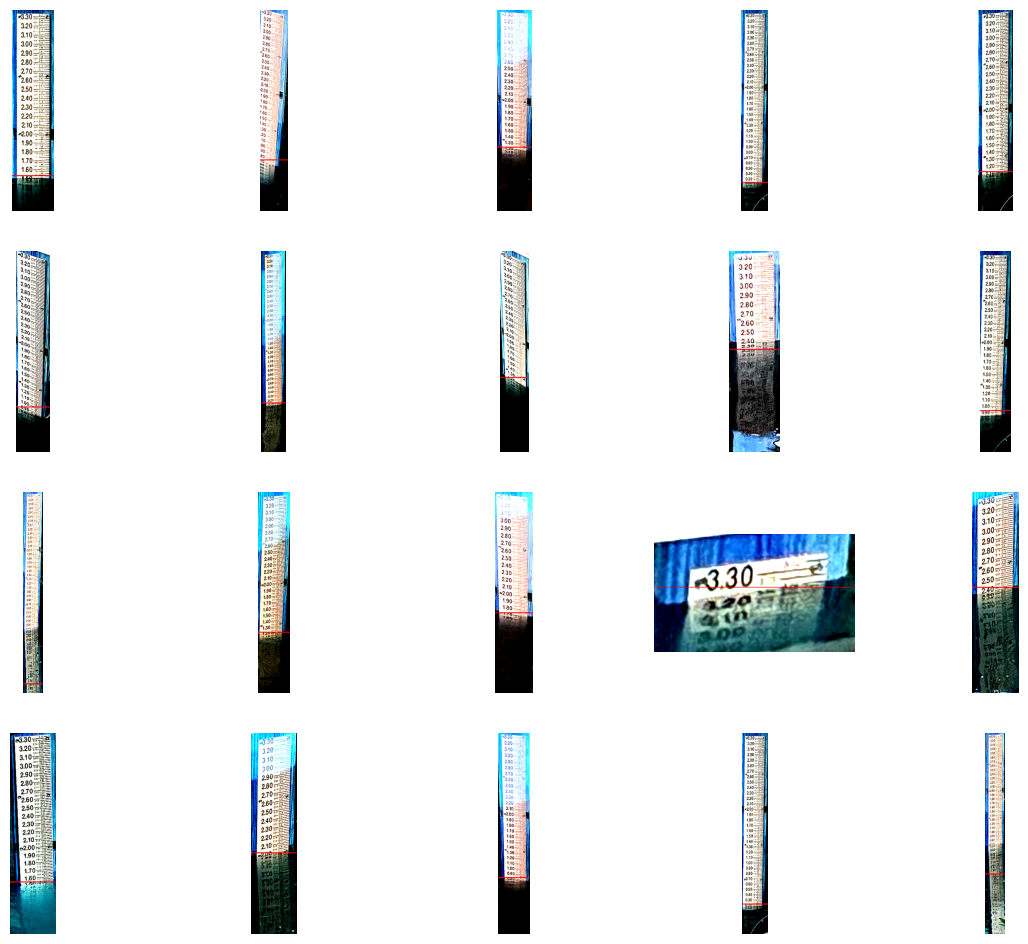

In [25]:
from PIL import Image, ImageFilter
import numpy as np

fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, prediction in enumerate(pred):
    row = i // 5
    col = i % 5

    # prediction=pred[4]
    label1, label2 = prediction.boxes[0].cls.cpu().numpy().astype(int)[0], prediction.boxes[1].cls.cpu().numpy().astype(int)[0]
    x1, y1, x2, y2 = map(int, prediction[1].boxes[0].xyxy[0]) if label1 == 1 else map(int, prediction[0].boxes[0].xyxy[0])

    stationLabel = prediction.plot(labels=False, boxes=False)[y1:y2, x1:x2]

    preprocessor = GaugePreprocessor()
    stationLabel = preprocessor.preprocess(stationLabel)

    processed_pil = Image.fromarray((stationLabel * 255).astype(np.uint8))
    processed_pil.save(f"data/preprocessed_images/gauge/gauge{i}.png")

    axes[row, col].imshow(stationLabel, cmap="gray")

    axes[row, col].axis('off')
print("Saved all detected gauge images.")
plt.show()

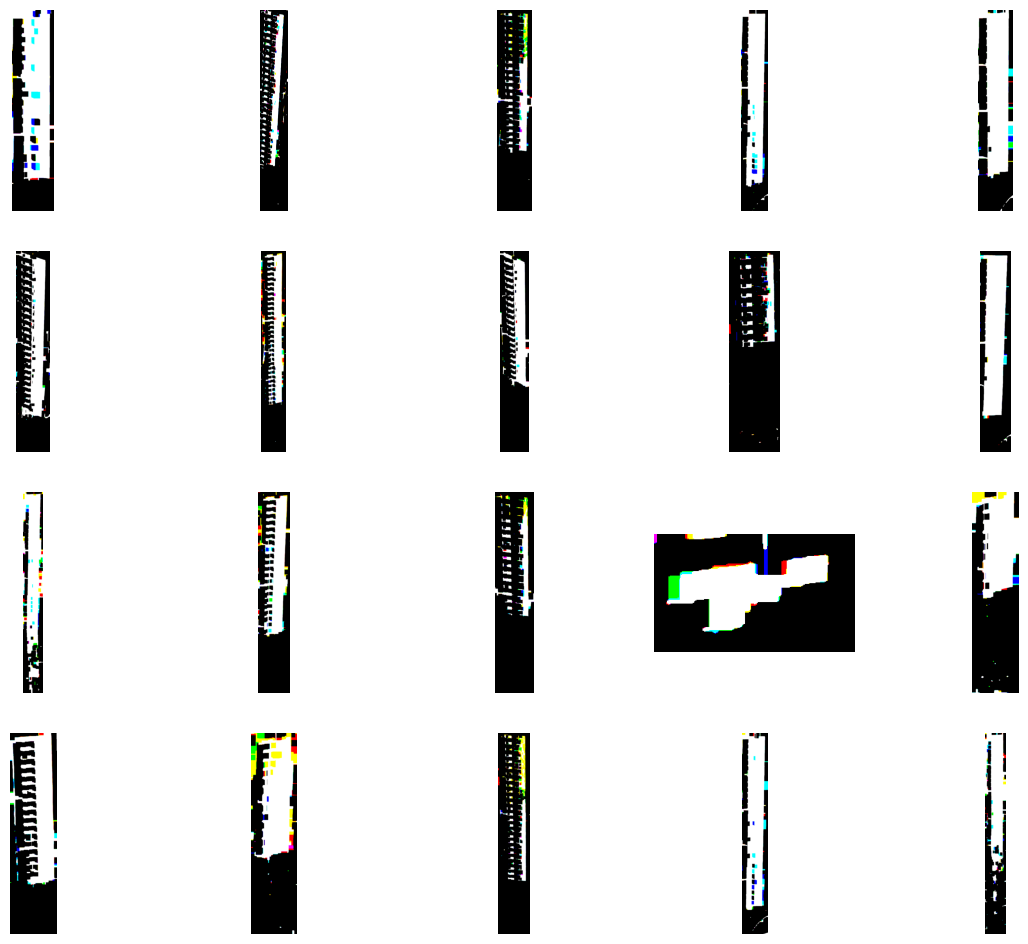

In [42]:
from PIL import Image, ImageFilter
import numpy as np

fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, prediction in enumerate(pred):
    row = i // 5
    col = i % 5

    # prediction=pred[4]
    label1, label2 = prediction.boxes[0].cls.cpu().numpy().astype(int)[0], prediction.boxes[1].cls.cpu().numpy().astype(int)[0]
    x1, y1, x2, y2 = map(int, prediction[1].boxes[0].xyxy[0]) if label1 == 1 else map(int, prediction[0].boxes[0].xyxy[0])

    stationLabel = prediction.plot(labels=False, boxes=False)[y1:y2, x1:x2]

    preprocessor = GaugePreprocessor()
    stationLabel = preprocessor.preprocess(stationLabel)

    processed_pil = Image.fromarray((stationLabel * 255).astype(np.uint8))
    processed_pil.save(f"data/preprocessed_images/gauge/gauge{i}.png")

    axes[row, col].imshow(stationLabel, cmap="gray")

    axes[row, col].axis('off')
plt.show()

In [15]:
from PIL import Image, ImageFilter, ImageEnhance, ImageOps
import torchvision.transforms as T
import numpy as np

# fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, prediction in enumerate(pred):
    row = i // 5
    col = i % 5

    # prediction = pred[19]

    label1, label2 = prediction.boxes[0].cls.cpu().numpy().astype(int)[0], prediction.boxes[1].cls.cpu().numpy().astype(int)[0]
    x1, y1, x2, y2 = map(int, prediction[1].boxes[0].xyxy[0]) if label1 == 0 else map(int, prediction[0].boxes[0].xyxy[0])

    stationLabel = prediction.plot(labels=False, boxes=False)[y1:y2, x1:x2]

    preprocessor = StationLabelPreprocessor()
    # stationLabel = preprocessor.preprocess(stationLabel)

    processed_pil = Image.fromarray((stationLabel * 255).astype(np.uint8))
    processed_pil.save(f"data/preprocessed_images/stationLabels/stationLabel{i}.png")

    # axes[row, col].imshow(stationLabel, cmap="gray")

    # axes[row, col].axis('off')

# plt.show()

In [ ]:
stations = ["NY1019", "NY1021", "NY1010", "NY1003", "NY1025", "NY1022", "NY1020", "NY1011", "NY1009", "NY1002", "NY1004", "NY1006", "NY1005", "NY1008", "NY1007", "NY1000", "PA1002", "PA1001", "PA1000", "WI1020", "WI2017", "WI2016", "WI2015", "WI2014", "WI2013", "WI2012", "WI2011", "WI2010", "WI2009", "WI2008", "WI2007", "WI2006", "WI2005", "WI2004", "WI2003", "WI2002", "WI2001", "WI9007", "WI9006", "WI9005", "WI9004", "WI9003", "WI9002", "WI9001", "WI9000", "WI1010", "NL1001", "NL1005", "NL1009", "WI1002", "WI1007", "WI1004", "NL1008", "NL1004", "NL1007", "NL1006", "WI1005", "WI1003", "WI1001", "WI1000", "UT1000", "OR1000", "OR1001", "NE1001", "NE1000", "MN1008", "MN1010", "MN1007", "MN1006", "MN1005", "MN1004", "MN1003", "MN1002", "MN1001", "MN1000", "MI1061", "MI1060", "MI1059", "MI1058", "MI1057", "MI1056", "MI1055", "MI1031", "MI1030", "MI1029", "MI1027", "MI1033", "MI1026", "MI1025", "MI1024", "MI1023", "MI1022", "MI1021", "MI1020", "MI1018", "MI1019", "MI1017", "MI1016", "MI1015", "MI1007", "MI1006", "MI1004", "MI1003", "MI1002", "MI1001", "MI1000", "MD1001", "MD1000", "IA1003", "IA1002", "IA1001", "IA1000", "MI1028", "CA1001", "CA1000", "AL1000", "MI1041", "NY1001", "NY1024", "MI1032", "MI2026", "MI2025", "MI2024", "MI2023", "MI2022", "IL1001", "IL1002", "IL1004", "AZ1006", "AZ1002", "AZ1014", "AZ1001", "AZ1007", "AZ1004", "AZ1011", "AZ1012", "AZ1000", "AZ1008", "AZ1009", "AZ1003", "AZ1010", "AZ1005", "AZ1016", "AZ1017", "AZ1019", "AZ1020", "AZ1022", "MN1016", "MN1015", "MN1014", "MN1013", "MN1012", "MN1011", "AZ1013", "MT1000", "MO1001", "MO1000", "NY1038", "AZ1027", "AZ1028", "AZ1029", "AZ1030", "MN1018", "NY1039", "CA1002", "OH1000", "IL1003", "IL1005", "OH1001", "OH1002", "OH1003", "OH1004", "AZ1015", "MN1026", "MN1027", "MN1028", "NC1000", "IL1007", "MN1019", "MN1020", "MI1052", "MN1021", "IN1002", "IN1003", "IN1004", "NJ1001", "IN1005", "LA1000", "LA1001", "LA1002", "LA1003", "LA1004", "LA1005", "MS1000", "MS1001", "MS1002", "MS1003", "NY1044", "WI1021", "OH1005", "NH1000", "OH1007", "NY9999", "PA1014", "OH1009", "OH1010", "OH1011", "OH1008", "OH1012", "PA1003", "PA1004", "PA1005", "PA1006", "PA1007", "PA1008", "PA1009", "PA1010", "PA1011", "PA1012", "PA1013", "PA1015", "PA1016", "PA1017", "PA1018", "PA1019", "PA1020", "PA1021", "PA1022", "PA1023", "PA1024", "PA1025", "PA1026", "PA1027", "PA1028", "PA1029", "PA1030", "PA1031", "MI1063", "OH1013", "OH1014", "OH1015", "OH1016", "OH1017", "MI1067", "OH1021", "OH1022", "OH1023", "OH1024", "OH1025", "OH1026", "OH1027", "OH1028", "NH1001", "NY1047", "NY1046", "NY1051", "NY1050", "NY1049", "NY1048", "NY1045", "PA1032", "NY1234", "WV1000", "OH1018", "OH1019", "OH1020", "WA1000", "OH1029", "OH1030", "OH1031", "OH1032", "OH1033", "OH1034"]
import csv

with open('stations.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Station'])
    for station in stations:
        writer.writerow([station])